# Estimating COVID-19's $R_t$ in Real-Time with PYMC3

Kevin Systrom - April 22

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

This notebook is a WIP - I'll add more context and commentary over the coming week.

In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load State Information
#### Load

In [2]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     parse_dates=['date'],
                     index_col=['state', 'date']).sort_index()

# Note: GU/AS/VI do not have enough data for this model to run


# Note: PR had -384 change recently in total count so unable to model
states = states.drop(['MP', 'GU', 'AS', 'PR', 'VI'])

#### Clean data with known modifications

In [3]:
# Errors in Covidtracking.com
states.loc[('WA','2020-04-21'), 'positive'] = 12512
states.loc[('WA','2020-04-22'), 'positive'] = 12753 
states.loc[('WA','2020-04-23'), 'positive'] = 12753 + 190

states.loc[('VA', '2020-04-22'), 'positive'] = 10266
states.loc[('VA', '2020-04-23'), 'positive'] = 10988

states.loc[('PA', '2020-04-22'), 'positive'] = 35684
states.loc[('PA', '2020-04-23'), 'positive'] = 37053

states.loc[('MA', '2020-04-20'), 'positive'] = 39643

states.loc[('CT', '2020-04-18'), 'positive'] = 17550
states.loc[('CT', '2020-04-19'), 'positive'] = 17962

states.loc[('HI', '2020-04-22'), 'positive'] = 586

states.loc[('RI', '2020-03-07'), 'positive'] = 3

#### Integrity Check

In [4]:
## TEST ##
today = datetime.combine(date.today(), datetime.min.time())
today

datetime.datetime(2020, 5, 5, 0, 0)

In [5]:
last_updated = states.reset_index('date').groupby('state')['date'].max()
print(last_updated)
type(last_updated)

state
AK   2020-05-04
AL   2020-05-04
AR   2020-05-04
AZ   2020-05-04
CA   2020-05-04
CO   2020-05-04
CT   2020-05-04
DC   2020-05-04
DE   2020-05-04
FL   2020-05-04
GA   2020-05-04
HI   2020-05-04
IA   2020-05-04
ID   2020-05-04
IL   2020-05-04
IN   2020-05-04
KS   2020-05-04
KY   2020-05-04
LA   2020-05-04
MA   2020-05-04
MD   2020-05-04
ME   2020-05-04
MI   2020-05-04
MN   2020-05-04
MO   2020-05-04
MS   2020-05-04
MT   2020-05-04
NC   2020-05-04
ND   2020-05-04
NE   2020-05-04
NH   2020-05-04
NJ   2020-05-04
NM   2020-05-04
NV   2020-05-04
NY   2020-05-04
OH   2020-05-04
OK   2020-05-04
OR   2020-05-04
PA   2020-05-04
RI   2020-05-04
SC   2020-05-04
SD   2020-05-04
TN   2020-05-04
TX   2020-05-04
UT   2020-05-04
VA   2020-05-04
VT   2020-05-04
WA   2020-05-04
WI   2020-05-04
WV   2020-05-04
WY   2020-05-04
Name: date, dtype: datetime64[ns]


pandas.core.series.Series

In [6]:
is_current = last_updated < today
print(is_current.sum())

51


In [7]:
# Make sure that all the states have current data
#today = datetime.combine(date.today(), datetime.min.time())
#last_updated = states.reset_index('date').groupby('state')['date'].max()
#is_current = last_updated < today

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all states have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for state, grp in states.groupby('state'):
    new_cases = grp.positive.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {state} has date with negative case counts")
        display(new_cases[~is_positive])
        
# Let's make sure that states have added cases
idx = pd.IndexSlice
assert not states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna().eq(0).any()

Not all states have updated


state
AK   2020-05-04
AL   2020-05-04
AR   2020-05-04
AZ   2020-05-04
CA   2020-05-04
CO   2020-05-04
CT   2020-05-04
DC   2020-05-04
DE   2020-05-04
FL   2020-05-04
GA   2020-05-04
HI   2020-05-04
IA   2020-05-04
ID   2020-05-04
IL   2020-05-04
IN   2020-05-04
KS   2020-05-04
KY   2020-05-04
LA   2020-05-04
MA   2020-05-04
MD   2020-05-04
ME   2020-05-04
MI   2020-05-04
MN   2020-05-04
MO   2020-05-04
MS   2020-05-04
MT   2020-05-04
NC   2020-05-04
ND   2020-05-04
NE   2020-05-04
NH   2020-05-04
NJ   2020-05-04
NM   2020-05-04
NV   2020-05-04
NY   2020-05-04
OH   2020-05-04
OK   2020-05-04
OR   2020-05-04
PA   2020-05-04
RI   2020-05-04
SC   2020-05-04
SD   2020-05-04
TN   2020-05-04
TX   2020-05-04
UT   2020-05-04
VA   2020-05-04
VT   2020-05-04
WA   2020-05-04
WI   2020-05-04
WV   2020-05-04
WY   2020-05-04
Name: date, dtype: datetime64[ns]

state  date      
MA     2020-04-20   -177.0
Name: positive, dtype: float64

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [8]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
LINELIST_PATH = 'data/linelist.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


#### Parse & Clean Patient Info

In [9]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

#### Show Relationship between Onset of Symptoms and Confirmation

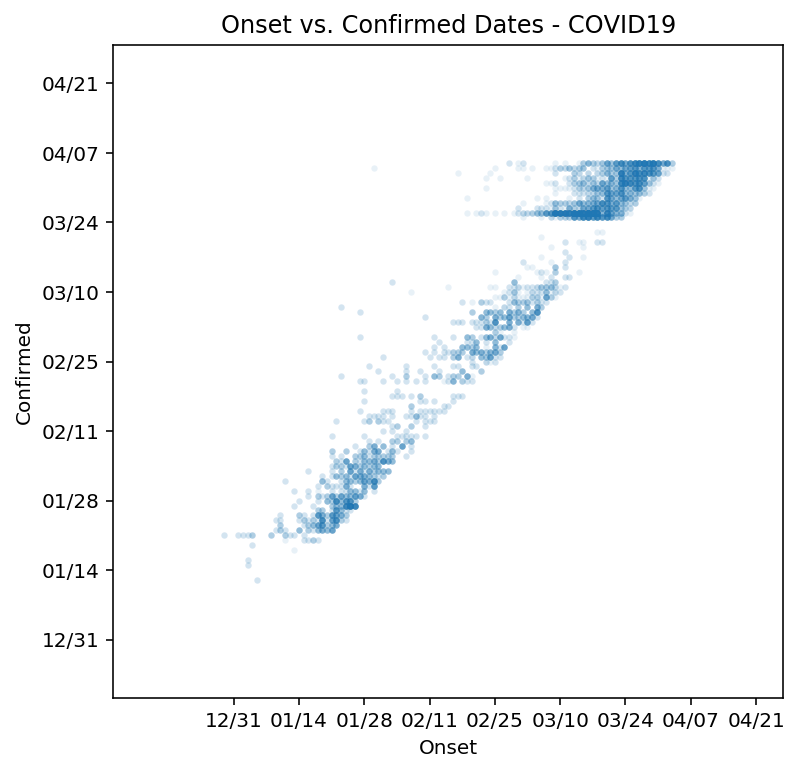

In [10]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

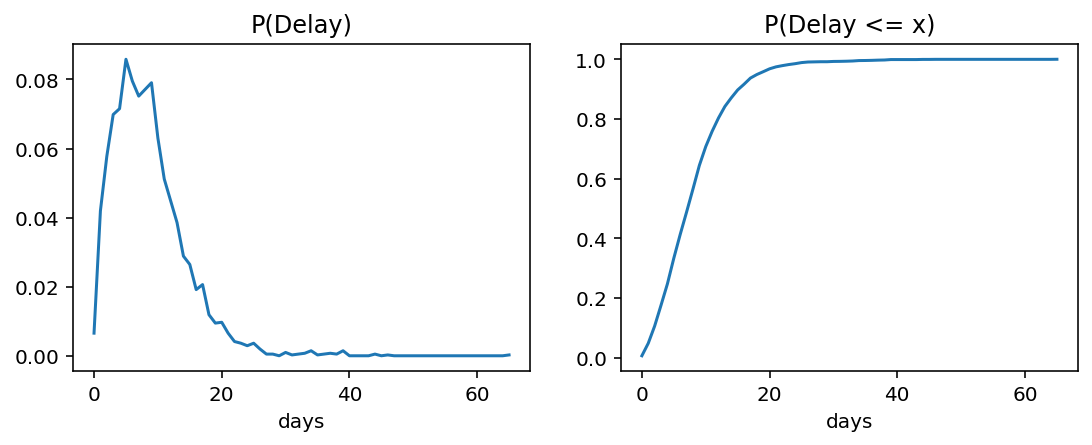

In [13]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

## A Single State

#### Select State Data

In [14]:
state = 'NY'
confirmed = states.xs(state).positive.diff().dropna()
confirmed.tail()

date
2020-04-30    4681.0
2020-05-01    3942.0
2020-05-02    4663.0
2020-05-03    3438.0
2020-05-04    2538.0
Name: positive, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [15]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset


onset = confirmed_to_onset(confirmed, p_delay)

In [16]:
onset

2019-12-31      0.003880
2020-01-01      0.002667
2020-01-02      0.010427
2020-01-03      0.007032
2020-01-04      0.008972
                 ...    
2020-04-30    886.760669
2020-05-01    597.071048
2020-05-02    321.221872
2020-05-03    128.976722
2020-05-04     16.616392
Freq: D, Length: 126, dtype: float64

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [17]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

In [18]:
adjusted

2019-12-31       0.003880
2020-01-01       0.002667
2020-01-02       0.010427
2020-01-03       0.007032
2020-01-04       0.008972
                 ...     
2020-04-30    3581.783546
2020-05-01    3391.626722
2020-05-02    3024.472603
2020-05-03    2659.500000
2020-05-04    2538.000000
Freq: D, Length: 126, dtype: float64

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

In [19]:
cumulative_p_delay

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99975752, 0.99975752, 0.99975752, 0.99975752,
       0.99975752, 0.99975752, 0.99975752, 0.99975752, 0.99975752,
       0.99975752, 0.99975752, 0.99975752, 0.99975752, 0.99975

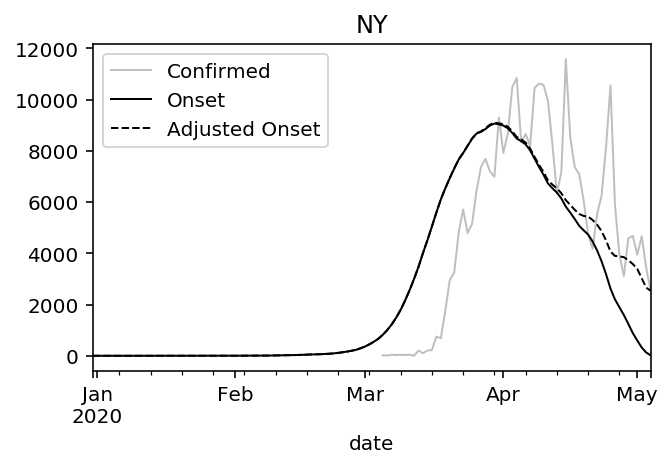

In [20]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=state,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [21]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [22]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(state, name):
    confirmed = state.positive.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [23]:
models = {}

for state, grp in states.groupby('state'):
    
    print(state)
    
    if state in models:
        print(f'Skipping {state}, already in cache')
        continue
    
    models[state] = create_and_run_model(grp.droplevel(0), state)
    

AK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 178.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


AL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:43<00:00, 92.08it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


AR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:39<00:00, 100.94it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


AZ


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:39<00:00, 101.76it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


CA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:17<00:00, 51.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


CO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:46<00:00, 85.16it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


CT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:57<00:00, 69.66it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


DC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:31<00:00, 127.45it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


DE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:31<00:00, 128.12it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


FL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:56<00:00, 71.12it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:50<00:00, 78.90it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


HI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 210.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:32<00:00, 121.60it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


ID


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:29<00:00, 136.41it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8661856502646961, but should be close to 0.95. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:54<00:00, 73.96it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:47<00:00, 83.37it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


KS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:30<00:00, 131.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


KY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:31<00:00, 126.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:55<00:00, 71.66it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:59<00:00, 67.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:53<00:00, 74.71it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


ME


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:20<00:00, 192.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:46<00:00, 86.65it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:36<00:00, 110.54it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:44<00:00, 90.04it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:41<00:00, 96.48it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


MT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 174.28it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:47<00:00, 84.87it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


ND


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:35<00:00, 112.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:42<00:00, 94.12it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


NH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:35<00:00, 112.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NJ


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:26<00:00, 46.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:36<00:00, 109.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:41<00:00, 95.99it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [02:05<00:00, 31.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


OH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:05<00:00, 61.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


OK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:40<00:00, 98.18it/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


OR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:36<00:00, 110.26it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:14<00:00, 53.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


RI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:46<00:00, 86.35it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


SC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 2 divergences: 100%|██████████| 4000/4000 [00:45<00:00, 88.70it/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


SD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:40<00:00, 99.51it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:49<00:00, 81.50it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:12<00:00, 55.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


UT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:38<00:00, 103.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:00<00:00, 66.06it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


VT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:30<00:00, 129.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


WA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:45<00:00, 87.21it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


WI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 2 divergences: 100%|██████████| 4000/4000 [00:39<00:00, 100.76it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


WV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:33<00:00, 118.68it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


WY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 164.28it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Handle Divergences

In [24]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


DC    1
ID    1
OK    1
SC    2
WI    2
WV    1
dtype: int64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:38<00:00, 102.93it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:38<00:00, 104.58it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:41<00:00, 97.49it/s] 
Only one chain was sam

## Compile Results

In [25]:
results = None

for state, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

### Render to CSV
Uncomment if you'd like

In [26]:
#Added code
from datetime import datetime
time_format = datetime.today().strftime("%Y_%m_%d")


results.to_csv('data/rt_{}.csv'.format(time_format))

### Render Charts

In [27]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0.5, 1.6)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_90'].values,
        result['upper_90'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

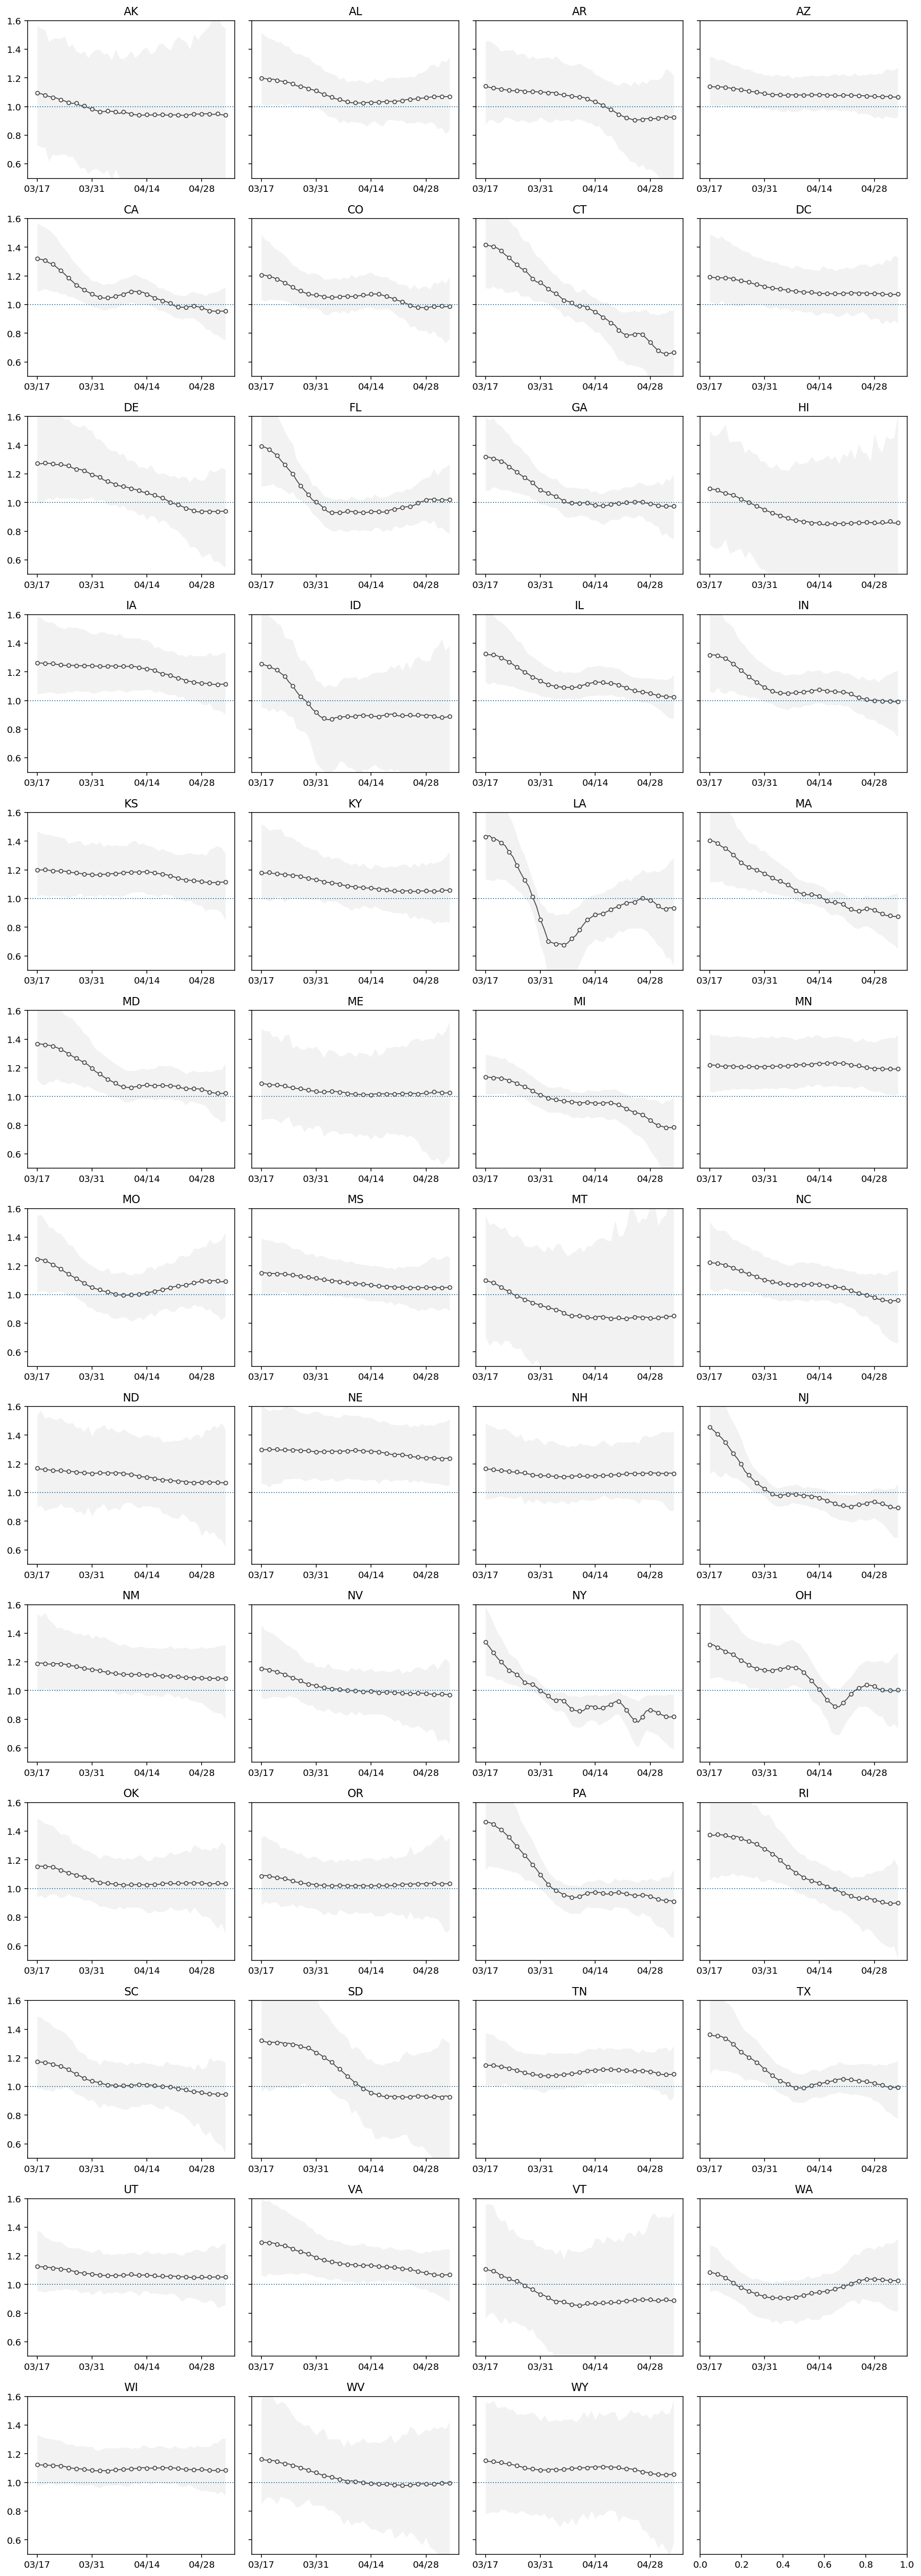

In [28]:
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')

(18322, 18386.0)

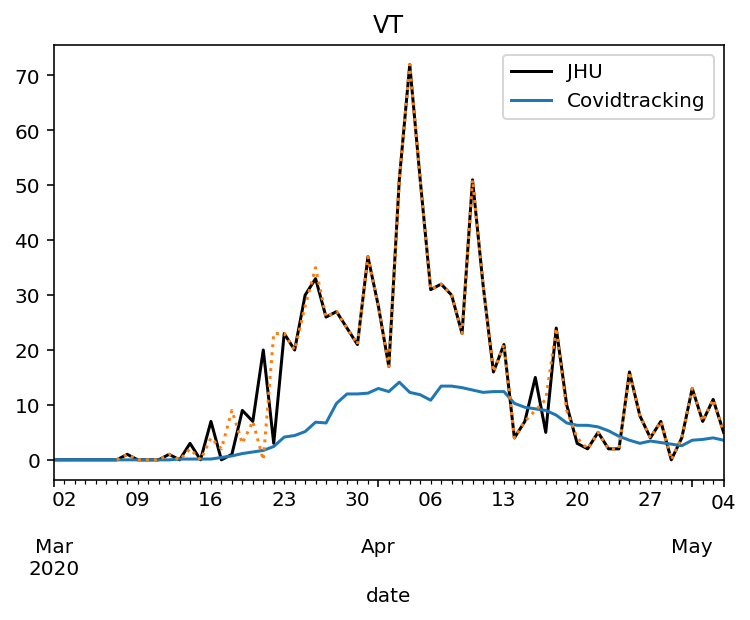

In [29]:
url = 'https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv'
abbrev = pd.read_csv(url, index_col=['State'], squeeze=True)

jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
jhu = pd.read_csv(jhu_url)

jhu = jhu.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
jhu = jhu.set_index('Province_State')
jhu.index = jhu.index.rename('region')
jhu = jhu.drop([
     'American Samoa',
     'Guam',
     'Northern Mariana Islands',
     'Puerto Rico',
     'Virgin Islands',
     'Diamond Princess',
     'Grand Princess'])

jhu.index = pd.Index(jhu.index.to_series().replace(abbrev).values, name='region')
jhu.columns = pd.to_datetime(jhu.columns)
jhu = jhu.groupby('region').sum()
jhu = jhu.stack().sort_index()

state = 'VT'
ax = jhu.xs(state).diff().plot(label='JHU', color='k', legend=True, title=state)
jhu.xs('AK').diff().rolling(7).mean().plot(ax=ax)
states.xs(state).positive.diff().plot(ax=ax, figsize=(6,4), linestyle=':', label='Covidtracking', legend=True)
ax.set_xlim(pd.Timestamp('2020-03-01'),None)

In [30]:
#url = 'https://raw.githubusercontent.com/epiforecasts/covid-regional/3ad63ea1acceb797f0628a8037fc206342d267e7/united-states/regional-summary/rt.csv'
#
#epf = pd.read_csv(url, parse_dates=['date'])
#epf.region = epf.region.replace(abbrev)
#epf = epf.set_index(['region', 'date']).sort_index()
#epf = epf.drop(['Guam', 'Puerto Rico'])
#
#epf_lookup = {}
#for idx, grp in epf.groupby('region'):
#    epf_lookup[idx]=grp
#    epf_grp = epf_lookup[idx]
#    
#    plot_rt(idx, result.droplevel(0), ax)
#    plot_rt(idx, epf_grp.droplevel(0), ax, c=(1,0,0,1))